In [1]:
from fccd.models.GBT import LightGBMModel, RandomForestModel
from fccd.util import limit_psd, collect_dataloader
from sklearn.preprocessing import MinMaxScaler

import pandas as pd

from fccd.data.modules import CDDDataModule

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import mean_squared_error

%load_ext autoreload
%autoreload 2

/Users/bob/.venvs/dev/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/bob/.venvs/dev/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  Referenced from: /Users/bob/.venvs/dev/lib/python3.10/site-packages/torchvision/image.so
  Expected in: /Users/bob/.venvs/dev/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


# Feature importance plotting

GBT models allow to gain insights into the importance it attributes to each features. We create a heatmap plot to see which feature is important at which time step. We create *T* GBT models and each provides feature importance measures.

### Why T GBTs?
The GBT model does not allow multi-output regression, hence we use a MultiOutput wrapper (sklearn) that fits one model for each time step. As a result we get *T* models each responsible for only making predictions for one time step.

### How does feature importance work?
GBTs are ensembles of decision trees. The trees are fit subsequentely and each GBT learns to correct the error of its predecessor. To do so, a single decision tree uses splits that maximize the information gain (or equivalently the loss). A split is selected if its information gain is maximal. This gives us two proxies of the feature importance:

1) We can use the number of times a feature is selected by a decision tree. Using GBT with 500 trees, the maximum feature importance is 500, if 500 subsequent trees split using the same attribute.

2) We can also use the information gain each each split provides (when selected as best split). 


In [2]:
# Collect dataset and fit models

feature_importance_measure="split"
#feature_importance_measure="gain"

def plot_feature_importance(datamodule):
    # Prepare Data
    train_dataloader = datamodule.train_dataloader()
    val_dataloader = datamodule.val_dataloader()
    test_dataloader = datamodule.test_dataloader()

    X_train, y_train = collect_dataloader(train_dataloader)
    X_val, y_val = collect_dataloader(val_dataloader)
    X_test, y_test = collect_dataloader(test_dataloader)
    
    col_names = datamodule.train_dataset().groups[0][0]["names"]
    X_train = pd.DataFrame(X_train, columns=col_names)
    
    # Prepare Estimator
    #pre_estimator = RandomForestModel()
    pre_estimator = LightGBMModel(max_depth=2, early_stopping_patience=1, n_estimators=200, learning_rate=0.1, feature_importance=feature_importance_measure)
    
    pre_estimator.fit(X_train, y_train, X_val=X_val, y_val=y_val)
    
    feature_importances = [model.feature_importances_ for model in pre_estimator.model.estimators_]
    feature_importances = pd.DataFrame(np.asarray(feature_importances).T, index=col_names)
    
    rmse = np.sqrt(mean_squared_error(pre_estimator.predict(X_test), y_test))
    print("Model RMSE", rmse)
    
        
    sns.set(font_scale=1.6)
    sns.set_style({'font.family':'serif', 'font.serif':'Linux Libertine O'})
        
    plt.figure(figsize=(10,5))
    sns.heatmap(feature_importances, )
    plt.xlabel("t")
    
    return pre_estimator

# Single Target Predictions

We train a GBT model and plot the feature importance for single-target and single-material predictions. We also take a look at the performance of the GBT model, since reliable feature importane estimates require a reliable prediction quality. 

Loading all datasets and plotting their feature importance requires some memory. For loading all 9 datasets you should have ~16GB of free memory.

In [3]:
# Read data
cu_125 = pd.read_csv("../data/processed/cu_125.csv", index_col=0)
cu_1000 = pd.read_csv("../data/processed/cu_1000.csv", index_col=0)

al_125 = pd.read_csv("../data/processed/al_125.csv", index_col=0)
al_1000 = pd.read_csv("../data/processed/al_1000.csv", index_col=0)

au_125 = pd.read_csv("../data/processed/au_125.csv", index_col=0)
au_1000 = pd.read_csv("../data/processed/au_1000.csv", index_col=0)

data_single = pd.concat([cu_125])
#data_single = pd.concat([cu_125, cu_1000, al_125, al_1000, au_125, au_1000])   # Loading all data (Memory-heavy)

data_single = data_single.reset_index(drop=True)

data_single["stress"] = data_single["stress"] * 1000
data_single["psd"] = data_single["psd"] * 1000

data_single = limit_psd(data_single)

In [4]:
# Specify the target and remove the other targets
target = "dislocation"
non_targets = ["stress", "time_ns", "strain"]

# Create datamodule
datamodule_single = CDDDataModule(
    data_single,
    target=target,
    psd="psd",
    group="id",
    drop_cols=non_targets,
    time="t",
    batch_size=64,
    categoricals=["material", "euler_angles", "mesh"],
    num_dataloader_workers=0,
    transform=MinMaxScaler,
    split_dataset=True,
)
datamodule_single.setup()

Model RMSE 0.025861070809946665


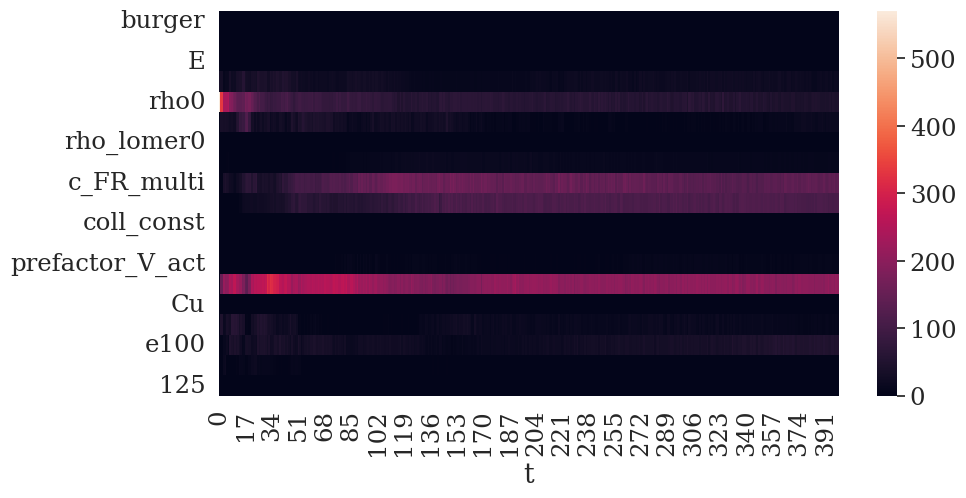

In [5]:
model = plot_feature_importance(datamodule_single)

RMSE:  0.014251564605391315


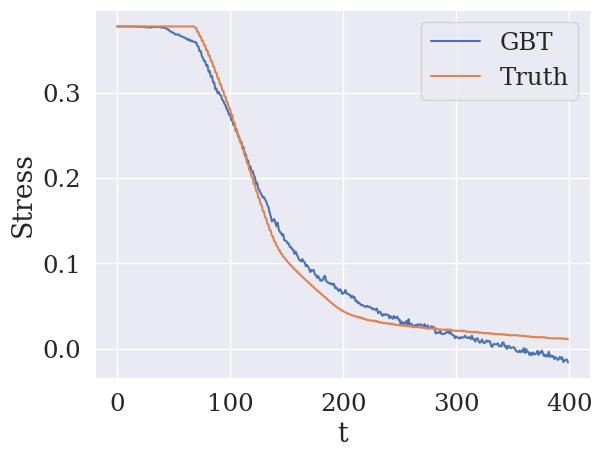

RMSE:  0.004744813100207728


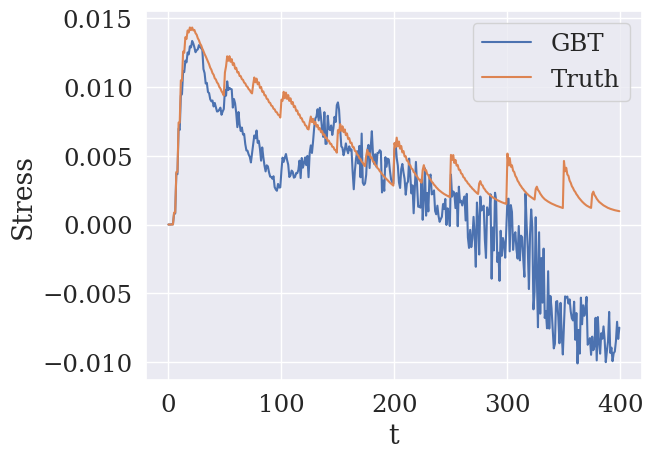

In [6]:
from fccd.util import plot_prediction_vs_truth_sklearn

plot_prediction_vs_truth_sklearn(datamodule_single.test_dataloader(), {"GBT": model}, 2)

# Multi Material Predictions

Next, we fo the same for multi-material predictions with a single-target.

In [7]:
dataset_names = ["cu_125", "cu_1000", "au_1000", "au_125", "al_1000", "al_125"]
datasets = [pd.read_csv(f"../data/processed/{name}.csv", index_col=0) for name in dataset_names]
data = pd.concat(datasets)
data = data.reset_index(drop=True)

# GPa to MPa
data["stress"] = data["stress"] * 1000
data["psd"] = data["psd"] * 1000

# 0.01 to 1%
data["strain"] = data["strain"] * 100

In [8]:
# Specify the target and remove the other targets
target = "dislocation"
non_targets = ["strain", "time_ns", "dislocation"]

# Create datamodule
datamodule = CDDDataModule(
    data,
    target=target,
    psd="psd",
    group="id",
    drop_cols=non_targets,
    time="t",
    batch_size=64,
    categoricals=["material", "euler_angles", "mesh"],
    num_dataloader_workers=4,
    transform=MinMaxScaler,
    split_dataset=True,
)
datamodule.setup()

KeyError: 'dislocation'

In [ ]:
plot_feature_importance(datamodule)

In [ ]:
plot_prediction_vs_truth_sklearn(datamodule.train_dataloader(), {"LGB": model}, 2)